In [1]:
using Pkg
Pkg.add(PackageSpec(url="https://github.com/esa-esdl/ESDL.jl"))
Pkg.add(PackageSpec(url="https://github.com/esa-esdl/ESDLPlots.jl"))
Pkg.add("WeightedOnlineStats")

    Updating git-repo `https://github.com/esa-esdl/ESDL.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
    Updating git-repo `https://github.com/esa-esdl/ESDLPlots.jl`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [2]:
using ESDL
using WeightedOnlineStats

In this Notebook we want to visualize the regions where cube variable take on their highest or lowest value. To do this we calculate the 99% and the 1% quantile for each variable from a subset of the data and afterwards count how often the quantile was exceeded for each variable in each grid cell.

In [4]:
c             = esdc() #Cube()
#vars          = ["air_temperature_2m","soil_moisture","gross_primary_productivity"];
vars          = ["air_temperature_2m","c_emissions","gross_primary_productivity"];
cdata         = subsetcube(c,region="South America",variable=vars,time=2001:2002)

YAXArray with the following dimensions
lon                 Axis with 208 Elements from -84.875 to -33.125
lat                 Axis with 300 Elements from 14.875 to -59.875
time                Axis with 92 Elements from 2001-01-05T00:00:00 to 2002-12-31T00:00:00
Variable            Axis with 3 elements: air_temperature_2m c_emissions gross_primary_productivity 
units: W m-2
Total size: 65.7 MB


Although it might seem to be a trivial task to estimate a quantile of some datacube variables, it actually isn't. For an exact quantile estimate, the whole dataset would need to be in memory. However, it is possible to get aproximate estimates of the quantiles by first fitting a `WeightedHistogram` provided by the [WeightedOnlineStats](https://github.com/gdkrmr/WeightedOnlineStats.jl) package and estimate the quantiles based on the Histogram. We first generate an iterable Table from the cube data:

In [5]:
t = CubeTable(cdata = cdata, include_axes=("lat","var"))

Datacube iterator with 17222400 elements with fields: ("cdata", "lat", "var")

This is a row iterator over the cube which will load data on demand. To fit a `WeightedHist` split by variable and weighted by cosine-latitude weights we use the convenience function `cubefittable` provided by the ESDL framework:

In [6]:
o = cubefittable(t,WeightedAdaptiveHist(200),:cdata,by=(:var,), weight=i->cosd(i.lat))

Progress: 100%|█████████████████████████████████████████| Time: 0:01:1139m


YAXArray with the following dimensions
Bin                 Axis with 200 Elements from 1 to 200
Hist                Axis with 2 elements: MidPoints Frequency 
Variable            Axis with 3 elements: air_temperature_2m c_emissions gross_primary_productivity 
Total size: 9.38 KB


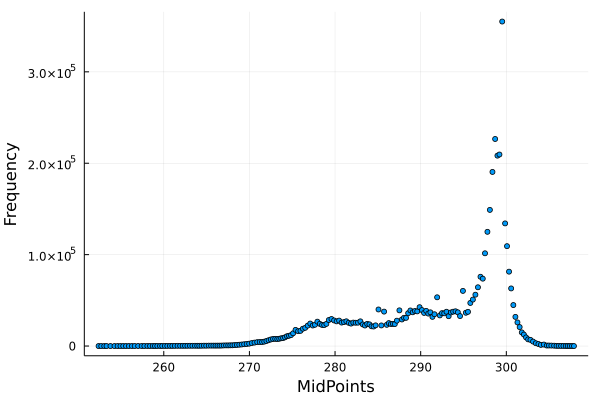

In [15]:
using ESDLPlots
#plotHist(o,var="soil_moisture")
plotHist(o,var="air_temperature_2m")

This datacube encodes a weighted Histogram for every variable with 100 bins. We can estimate the 1% and 99% quantiles from the Histogram:

In [7]:
q = quantile(o,[0.01,0.99])

YAXArray with the following dimensions
Quantile            Axis with 2 Elements from 0.01 to 0.99
Variable            Axis with 3 elements: air_temperature_2m c_emissions gross_primary_productivity 
Total size: 48.0 bytes


Now we can use the estimated quantiles to count for each pixel how often the quantile has been exceeded. TO do this, we define a function that counts quantile crossings for each grid cell:

In [8]:
"""
How often the upper or lower quantiles are crossed in each time series
"""
function countExtremes(xout::AbstractArray,xin::AbstractVector,qvec::AbstractVector)
    nlow,nhigh=0,0
    qlow,qhigh=qvec
    for v in xin
        if !ismissing(v)
            v<=qlow && (nlow+=1)
            v>=qhigh && (nhigh+=1)
        end
    end
    xout[1]=nhigh
    xout[2]=nlow
end

countExtremes

In [9]:
indims = InDims("Time"),InDims("Quantile")
outdims = OutDims(CategoricalAxis("Direction",["High","Low"]),outtype=Int)
tresexcount=mapCube(countExtremes,(cdata,q),
  indims = indims,
  outdims = outdims)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


YAXArray with the following dimensions
Direction           Axis with 2 elements: High Low 
lon                 Axis with 208 Elements from -84.875 to -33.125
lat                 Axis with 300 Elements from 14.875 to -59.875
Variable            Axis with 3 elements: air_temperature_2m c_emissions gross_primary_productivity 
Total size: 2.86 MB


Now we plot the low extremes

"air_temperature_2m"

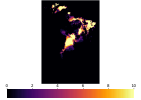

"c_emissions"

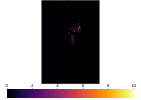

"gross_primary_productivity"

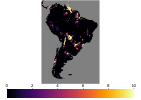

In [13]:
for v in getAxis("Var",o).values
display(v)
display(plotMAP(tresexcount,dmax=10,dir="High",var=v))
end

And the high extremes

"air_temperature_2m"

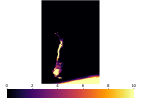

"c_emissions"

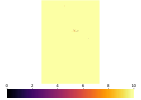

"gross_primary_productivity"

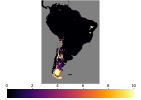

In [14]:
for v in getAxis("Var",o).values
display(v)
display(plotMAP(tresexcount,dmax=10,dir="Low",var=v))
end